### 1. Download and setup all necessary libraries.

In [3]:
!pip install maxvolpy tntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.6 MB/s 
  Created wheel for maxvolpy: filename=maxvolpy-0.3.8-cp38-cp38-linux_x86_64.whl size=398532 sha256=e857e3e06cd2b5fd9cb8fb96d9f02958be31c045371db0fa0e3d16b0cd02a608
  Stored in directory: /root/.cache/pip/wheels/f6/83/7a/62ce6db59e5e28cf6477b1dff6b39681328d4dd47a36a0fd9a
Successfully built maxvolpy


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

### 2. Experiment function

In [6]:
from tensor_extraction import extract_tensor_with_cross
from wfa_extraction import wfa_extraction, create_hankel_matrices, create_hankel_matrices_on_random_sets
from spectral_learning import spectral_learning
from utils import func_difference_metrics


def experiment(func, filename, alphabet_size_list, ranks_list, n_list, max_length, max_iter):
    df_result = pd.DataFrame(columns=['alphabet_size',
                                      'rank',
                                      'n',
                                      'n_evaluations',
                                      'error_max[cross]',
                                      'error_avg[cross]',
                                      'error_max[short]',
                                      'error_avg[short]',
                                      'error_max[random]',
                                      'error_avg[random]'])

    for alphabet_size in alphabet_size_list:
        print('Starting experiment with alphabet_size={}'.format(alphabet_size))

        F = func
        F.alphabet_size = alphabet_size

        for rank in ranks_list:
            print('Starting experiment with alphabet_size={}, rank={}'.format(alphabet_size, rank))
            for n in n_list:
                print('Starting experiment with alphabet_size={}, rank={}, n={}'.format(alphabet_size, rank, n))

                #tensor extraction
                tensor_extraction_time = time.time()
                tensor, info = extract_tensor_with_cross(F, n, rank=rank, max_iter=max_iter, return_info=True,
                                                         kickrank=rank, rmax=1000)
                tensor_extraction_time = time.time() - tensor_extraction_time
                print('Tensor was extracted, time={:.5}'.format(tensor_extraction_time))
                n_evaluations = info['nsamples']
                print('The number of evaluations was {}'.format(n_evaluations))
                #automaton extraction from tensor
                cross_wfa_extraction_time = time.time()
                W_cross = wfa_extraction(tensor, rank=rank)
                cross_wfa_extraction_time = time.time() - cross_wfa_extraction_time
                print('WFA was extracted from tensor, time={:.5}'.format(cross_wfa_extraction_time))

                #spectral learning [short]
                set_size = int(np.sqrt((n_evaluations + alphabet_size) // (alphabet_size + 1))) + 1
                print('The size of prefixes and suffixes set is {}'.format(set_size))
                set_size = max(set_size, rank + 1)
                #Hankel matrices creation
                hankel_creation_time = time.time()
                hPref, hSuf, H = create_hankel_matrices(F, kPref=set_size, kSuf=set_size)
                hankel_creation_time = time.time() - hankel_creation_time
                print('Hankel matrices has been created, time={:.5}'.format(hankel_creation_time))
                #automaton extraction from Hankel matrices
                spectral_wfa_extraction_time = time.time()
                W_spectral = spectral_learning(hPref, hSuf, H, rank)
                spectral_wfa_extraction_time = time.time() - spectral_wfa_extraction_time
                print('WFA was extracted from Hankel matrices, time={:.5}'.format(spectral_wfa_extraction_time))

                #spectral learning [random]
                #Hankel matrices creation
                random_hankel_creation_time = time.time()
                hPref, hSuf, H = create_hankel_matrices_on_random_sets(F, n, n, set_size, set_size)
                random_hankel_creation_time = time.time() - random_hankel_creation_time
                print('Hankel matrices has been created, time={:.5}'.format(random_hankel_creation_time))
                #automaton extraction from Hankel matrices
                random_spectral_wfa_extraction_time = time.time()
                W_random = spectral_learning(hPref, hSuf, H, rank)
                random_spectral_wfa_extraction_time = time.time() - random_spectral_wfa_extraction_time
                print('WFA was extracted from Hankel matrices, time={:.5}'.format(
                    random_spectral_wfa_extraction_time))

                # difference evaluation
                cross_error_max, cross_error_avg = func_difference_metrics(F, W_cross, max_length=max_length)
                print('errors has been evaluated\ncross_error_max={}\ncross_error_avg={}'.format(cross_error_max,
                                                                                                 cross_error_avg))
                spectral_error_max, spectral_error_avg = func_difference_metrics(F, W_spectral, max_length=max_length)
                print(
                    'errors has been evaluated\nspectral_error_max={}\nspectral_error_avg={}'.format(spectral_error_max,
                                                                                                     spectral_error_avg))
                random_spectral_error_max, random_spectral_error_avg = func_difference_metrics(F, W_spectral,
                                                                                               max_length=max_length)
                print('errors has been evaluated\nrandom_spectral_error_max={}\nrandom_spectral_error_avg={}'.format(
                    random_spectral_error_max, random_spectral_error_avg))

                df_result = df_result.append({'alphabet_size': alphabet_size,
                                              'rank': rank,
                                              'n': n,
                                              'n_evaluations': n_evaluations,
                                              'error_max[cross]': cross_error_max,
                                              'error_avg[cross]': cross_error_avg,
                                              'error_max[short]': spectral_error_max,
                                              'error_avg[short]': spectral_error_avg,
                                              'error_max[random]': random_spectral_error_max,
                                              'error_avg[random]': random_spectral_error_avg}, ignore_index=True)

        df_result.to_csv('csv_{}_{}.csv'.format(filename, alphabet_size))

    return df_result.astype({'alphabet_size': 'int64',
                             'rank': 'int64',
                             'n': 'int64',
                             'n_evaluations': 'int64'})

### 3. Experiment

In [7]:
from wfa_extraction import RandomNormalWFA


def test_function(seq):
    value = 0
    for x in seq:
        value += (x + 1) ** 2
    return np.sin(value) ** 3 * 0.1


class Sum:
    def __init__(self, A, noise):
        self.A = A
        self.noise = noise
        self.alphabet_size = A.alphabet_size

    def f(self, seq):
        return self.A.f(seq) + self.noise(seq)


W1 = RandomNormalWFA(20, 10, lval=0.5, rval=1.5, seed=239)
W = Sum(W1, test_function)

df_result = experiment(W, filename='wfa-tensor', alphabet_size_list=[10, 15, 20], ranks_list=[10], n_list=[1, 2, 3, 4],
                       max_length=10, max_iter=3)

Starting experiment with alphabet_size=10
Starting experiment with alphabet_size=10, rank=10
Starting experiment with alphabet_size=10, rank=10, n=1
cross device is None
Cross-approximation over a 3D domain containing 1331 grid points:
iter: 0 | eps: 9.904e-01 | time:   0.1243 | largest rank:   1
iter: 1 | eps: 4.102e-07 | time:   0.8628 | largest rank:  11 <- converged: eps < 1e-06
Did 3080 function evaluations, which took 0.6858s (4491 evals/s)

Tensor was extracted, time=1.2949
The number of evaluations was 3080
WFA was extracted from tensor, time=0.04353
The size of prefixes and suffixes set is 17
Hankel matrices has been created, time=0.065605
WFA was extracted from Hankel matrices, time=0.018677
Hankel matrices has been created, time=0.056491
WFA was extracted from Hankel matrices, time=0.0018573


/content/wfa_extraction.py:111: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  alpha_inf = W.cores[2 * N].T[0][0]


errors has been evaluated
cross_error_max=[0.06613456 0.11924581 0.17542229 0.32126732 1.22097297 1.42779162
 1.75555498 1.95476472 1.97547731 1.99677069 1.98471152]
cross_error_avg=[0.06613456 0.08922463 0.06659168 0.05687053 0.19126594 0.28921883
 0.3597778  0.44153296 0.49096989 0.55458549 0.60516881]
errors has been evaluated
spectral_error_max=[0.11997928 0.12020554 0.35438054 0.81994372 1.2485579  1.83485424
 1.88900106 1.88993908 1.88309311 1.98241111 1.98597538]
spectral_error_avg=[0.11997928 0.04657461 0.12312437 0.15097731 0.21000853 0.26214403
 0.32173496 0.36058277 0.3974437  0.43678681 0.49848093]
errors has been evaluated
random_spectral_error_max=[0.11997928 0.12020554 0.35438054 0.81994372 1.11712552 1.43882722
 1.48414631 1.97023751 1.9194839  1.93658594 1.99617518]
random_spectral_error_avg=[0.11997928 0.04657461 0.12312437 0.15097731 0.19707596 0.25586089
 0.29984797 0.3657487  0.41833998 0.4632241  0.47044627]
Starting experiment with alphabet_size=10, rank=10, n=2


| eps: 1.686e-06 | time:  20.5309 | largest rank:  21 <- max_iter was reached: 3
Did 53449 function evaluations, which took 20.31s (2632 evals/s)

Tensor was extracted, time=20.929
The number of evaluations was 53449
WFA was extracted from tensor, time=0.0032637
The size of prefixes and suffixes set is 70
Hankel matrices has been created, time=1.2239
WFA was extracted from Hankel matrices, time=0.0019758
Hankel matrices has been created, time=1.6253
WFA was extracted from Hankel matrices, time=0.0024652
errors has been evaluated
cross_error_max=[0.06443127 0.10654252 0.10515397 0.12370694 0.12313948 0.14256688
 0.13279628 0.15283727 0.15357719 0.18072435 0.1643747 ]
cross_error_avg=[0.06443127 0.04383277 0.04339224 0.04370809 0.042212   0.04166251
 0.04137642 0.04273085 0.04244349 0.04444979 0.04347275]
errors has been evaluated
spectral_error_max=[0.09324308 0.04886111 0.17644802 0.31449803 0.45981824 0.42408545
 0.58211027 0.69651773 0.67974153 0.66655101 1.30958648]
spectral_error_a

| eps: 2.278e-06 | time:  35.4772 | largest rank:  21 <- max_iter was reached: 3
Did 78221 function evaluations, which took 35.14s (2226 evals/s)

Tensor was extracted, time=35.943
The number of evaluations was 78221
WFA was extracted from tensor, time=0.0065768
The size of prefixes and suffixes set is 85
Hankel matrices has been created, time=1.7442
WFA was extracted from Hankel matrices, time=0.0024867
Hankel matrices has been created, time=3.0804
WFA was extracted from Hankel matrices, time=0.0029047
errors has been evaluated
cross_error_max=[0.06269042 0.10596628 0.10366917 0.1046465  0.11360799 0.11008777
 0.11515294 0.11028123 0.11167618 0.11231713 0.11177999]
cross_error_avg=[0.06269042 0.047373   0.04241687 0.04200929 0.04221954 0.0427662
 0.04127685 0.04134974 0.03978186 0.03970233 0.03992396]
errors has been evaluated
spectral_error_max=[0.05350798 0.08218726 0.20197098 0.25636732 0.30091688 0.30277995
 0.42662868 0.54331164 0.53057703 0.94270875 1.16834514]
spectral_error_av

| eps: 1.036e-06 | time:  14.4750 | largest rank:  21 <- max_iter was reached: 3
Did 48672 function evaluations, which took 14.35s (3391 evals/s)

Tensor was extracted, time=14.791
The number of evaluations was 48672
WFA was extracted from tensor, time=0.0041087
The size of prefixes and suffixes set is 56
Hankel matrices has been created, time=1.0036
WFA was extracted from Hankel matrices, time=0.0028348
Hankel matrices has been created, time=1.2247
WFA was extracted from Hankel matrices, time=0.002223
errors has been evaluated
cross_error_max=[0.06864908 0.11476708 0.1245505  0.15323587 0.1428247  0.18138431
 0.18868868 0.1954934  0.29342446 0.252963   0.55267726]
cross_error_avg=[0.06864908 0.05387998 0.04665106 0.04548816 0.04507704 0.04500515
 0.04820915 0.04742303 0.05086375 0.05015637 0.05266016]
errors has been evaluated
spectral_error_max=[0.07098093 0.10934217 0.18008031 0.2489359  0.34060699 0.30035957
 0.36172114 0.55178036 0.62621393 0.72834867 0.53355013]
spectral_error_av

| eps: 1.690e-06 | time:  32.1148 | largest rank:  21 <- max_iter was reached: 3
Did 84704 function evaluations, which took 31.91s (2655 evals/s)

Tensor was extracted, time=32.509
The number of evaluations was 84704
WFA was extracted from tensor, time=0.0037279
The size of prefixes and suffixes set is 73
Hankel matrices has been created, time=1.6886
WFA was extracted from Hankel matrices, time=0.0015907
Hankel matrices has been created, time=2.6094
WFA was extracted from Hankel matrices, time=0.0015819
errors has been evaluated
cross_error_max=[0.06015749 0.10211305 0.10199842 0.11051518 0.10727634 0.11343968
 0.10422774 0.1091997  0.10940706 0.11444351 0.11884045]
cross_error_avg=[0.06015749 0.04965045 0.04257783 0.04203018 0.04189944 0.04037088
 0.04081456 0.03947682 0.03942302 0.03851498 0.03914901]
errors has been evaluated
spectral_error_max=[0.04403857 0.10602901 0.1539276  0.25294211 0.24828419 0.3327171
 0.49021846 0.57907958 0.48357385 0.58198357 1.13888442]
spectral_error_av

| eps: 2.775e-06 | time:  56.1955 | largest rank:  21 <- max_iter was reached: 3
Did 120736 function evaluations, which took 55.87s (2161 evals/s)

Tensor was extracted, time=56.675
The number of evaluations was 120736
WFA was extracted from tensor, time=0.0045698
The size of prefixes and suffixes set is 87
Hankel matrices has been created, time=2.5701
WFA was extracted from Hankel matrices, time=0.0027957
Hankel matrices has been created, time=4.6608
WFA was extracted from Hankel matrices, time=0.0025253
errors has been evaluated
cross_error_max=[0.05997313 0.10061986 0.10046682 0.10168432 0.10232938 0.10129624
 0.10211788 0.10555282 0.10378055 0.1041764  0.10307775]
cross_error_avg=[0.05997313 0.05036362 0.04249674 0.04173525 0.04426302 0.03981263
 0.03951822 0.04046126 0.0384187  0.0383652  0.03825574]
errors has been evaluated
spectral_error_max=[0.01043695 0.0777124  0.19085872 0.26003825 0.35269548 0.41236733
 0.54205518 0.53777123 0.61287643 0.70573808 0.83582681]
spectral_error

| eps: 2.046e-06 | time:  45.5359 | largest rank:  21 <- max_iter was reached: 3
Did 120309 function evaluations, which took 45.22s (2661 evals/s)

Tensor was extracted, time=45.939
The number of evaluations was 120309
WFA was extracted from tensor, time=0.0043867
The size of prefixes and suffixes set is 76
Hankel matrices has been created, time=2.4894
WFA was extracted from Hankel matrices, time=0.0031595
Hankel matrices has been created, time=3.9817
WFA was extracted from Hankel matrices, time=0.0016692
errors has been evaluated
cross_error_max=[0.05984301 0.10110578 0.10495759 0.11016883 0.10901764 0.11056
 0.11405672 0.12225665 0.12538647 0.12019001 0.12210044]
cross_error_avg=[0.05984301 0.04413295 0.04204982 0.04075081 0.04232063 0.04166328
 0.04195904 0.03970674 0.04030883 0.03882659 0.03987326]
errors has been evaluated
spectral_error_max=[0.05106364 0.10903952 0.2387919  0.309933   0.3188896  0.43401623
 0.45330646 0.73969331 0.78205154 0.73277079 0.80571539]
spectral_error_av

| eps: 2.534e-06 | time:  76.7022 | largest rank:  21 <- max_iter was reached: 3
Did 167601 function evaluations, which took 76.37s (2195 evals/s)

Tensor was extracted, time=77.208
The number of evaluations was 167601
WFA was extracted from tensor, time=0.008261
The size of prefixes and suffixes set is 90
Hankel matrices has been created, time=3.671
WFA was extracted from Hankel matrices, time=0.0019681
Hankel matrices has been created, time=6.5752
WFA was extracted from Hankel matrices, time=0.0027866
errors has been evaluated
cross_error_max=[0.05963272 0.10003449 0.10140175 0.10192697 0.10277104 0.10256085
 0.10272291 0.10214935 0.10279967 0.1028804  0.10213678]
cross_error_avg=[0.05963272 0.04528026 0.04177693 0.04148987 0.04295278 0.04227641
 0.04119096 0.03858967 0.03911069 0.03794398 0.03665252]
errors has been evaluated
spectral_error_max=[0.05541122 0.14644832 0.19547363 0.28475934 0.29367909 0.28695274
 0.30354739 0.53242666 0.73441878 0.65910292 0.92924144]
spectral_error_a

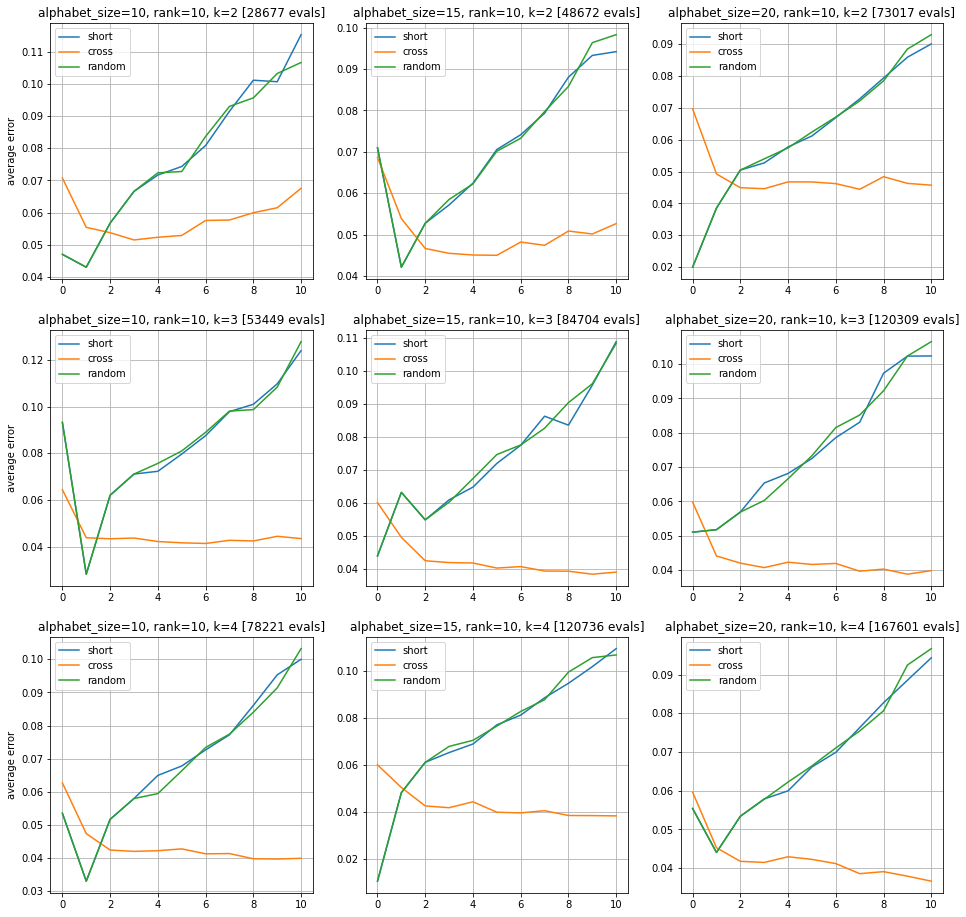

In [12]:
crop_len = 10

f, arr = plt.subplots(3, 3)
f.set_figheight(16)
f.set_figwidth(16)

cnt = 0
for index, row in df_result.iterrows():
    idx = np.arange(crop_len + 1)
    alphabet_size = row['alphabet_size']
    rank = row['rank']
    n = row['n']
    if n == 1:
        continue
    x = n - 2
    y = (alphabet_size // 5) - 2
    arr[x][y].plot(idx, row['error_avg[short]'][:(crop_len + 1)], label='short')
    arr[x][y].plot(idx, row['error_avg[cross]'][:(crop_len + 1)], label='cross')
    arr[x][y].plot(idx, row['error_avg[random]'][:(crop_len + 1)], label='random')
    arr[x][y].legend()
    arr[x][y].title.set_text(
        'alphabet_size={}, rank={}, k={} [{} evals]'.format(alphabet_size, rank, n, row['n_evaluations']))
    if y == 0:
        arr[x][y].set_ylabel('average error')
    if x == 3:
        arr[x][y].set_xlabel('length')
    arr[x][y].grid()
    cnt += 1

f.savefig('plots3.png', bbox_inches='tight', pad_inches=0.01)

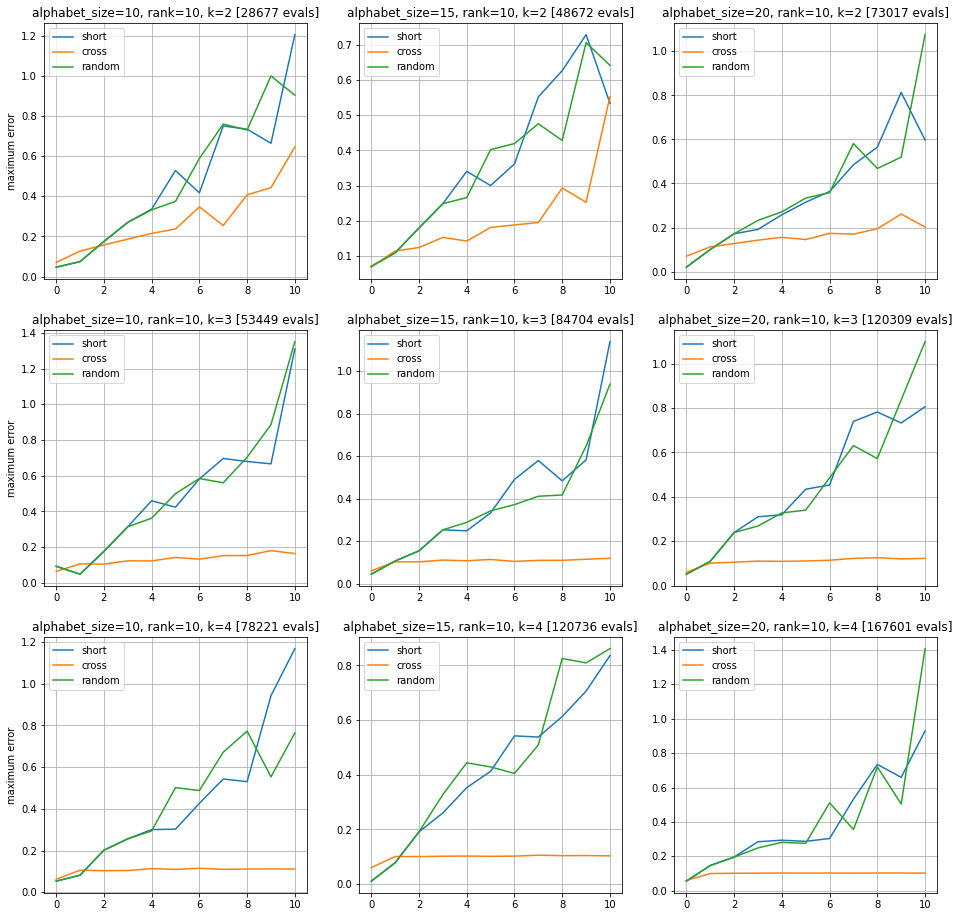

In [15]:
crop_len = 10

f, arr = plt.subplots(3, 3)
f.set_figheight(16)
f.set_figwidth(16)

cnt = 0
for index, row in df_result.iterrows():
    idx = np.arange(crop_len + 1)
    alphabet_size = row['alphabet_size']
    rank = row['rank']
    n = row['n']
    if n == 1:
        continue
    x = n - 2
    y = (alphabet_size // 5) - 2
    arr[x][y].plot(idx, row['error_max[short]'][:(crop_len + 1)], label='short')
    arr[x][y].plot(idx, row['error_max[cross]'][:(crop_len + 1)], label='cross')
    arr[x][y].plot(idx, row['error_max[random]'][:(crop_len + 1)], label='random')
    arr[x][y].legend()
    arr[x][y].title.set_text(
        'alphabet_size={}, rank={}, k={} [{} evals]'.format(alphabet_size, rank, n, row['n_evaluations']))
    if y == 0:
        arr[x][y].set_ylabel('maximum error')
    if x == 3:
        arr[x][y].set_xlabel('length')
    arr[x][y].grid()
    cnt += 1

f.savefig('plots4.png', bbox_inches='tight', pad_inches=0.01)